In [1]:
import pandas as pd
from utils.utilities import gridsearch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from utils.load import load_everthing
from utils.load import load

In [2]:

pipe = Pipeline( [("StandardScaler",StandardScaler()), ('rf', RandomForestRegressor())]) 
param_grid = { 'rf__max_features':[1.0], 'rf__n_estimators':[150], 'rf__max_depth':[None], 'rf__min_samples_split': [2], 'rf__min_samples_leaf': [2] }

In [3]:
boot_test = gridsearch(pipeline= pipe, param_grid= param_grid, remove_threshold= 1000)

Loading in data
16836
CosDist
running gridsearch
Best parameter (CV score=0.465):
{'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
---------------------------------------------------------------------------
EucDist
running gridsearch
Best parameter (CV score=0.291):
{'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
---------------------------------------------------------------------------
HetDist
running gridsearch
Best parameter (CV score=0.287):
{'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
---------------------------------------------------------------------------
ManDist
running gridsearch
Best parameter (CV score=0.261):
{'rf__max_depth': None, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators':

In [4]:
from joblib import load
clf = load('models_to_save/random_forrest_reg.pkl')


In [5]:
import os
from collections import defaultdict
from utils.utilities import remove_outside_confidence_interval

In [6]:
def gen_feature_dict_d_trees(bootstrap_results):
    param_list = [x.best_estimator_.steps[-1][-1].feature_importances_ for x in bootstrap_results]
    feature_list = []
    for file in os.listdir("data/fb_data/"):
        if ("CosDist" in file) and (file.endswith(".csv")) and (file != "FBCosDist.csv"):
            feature = file.split("_")[1]
            feature = feature.replace(".csv","")
            feature_list.append(feature)
    d = defaultdict(list)
    for run in param_list:
        for feature, value in zip(feature_list,run):
            d[feature].append(value)

    #Removes values outside n% confidence interval
    for key, val in d.items():
        n = 0.95
        d[key] = remove_outside_confidence_interval(n,val)
    return d

In [7]:
boot_test[0].gridsearch

GridSearchCV(estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=2,
             param_grid={'rf__max_depth': [None], 'rf__max_features': [1.0],
                         'rf__min_samples_leaf': [2],
                         'rf__min_samples_split': [2],
                         'rf__n_estimators': [150]},
             scoring='r2')

In [8]:
idk = [x.gridsearch for x in boot_test]

In [9]:
feature_dict = gen_feature_dict_d_trees(idk)

In [10]:
from utils.plots import plot_confidence_interval

/home/tjuppen/Documents/GitHub/Bachelor/utils/plots.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


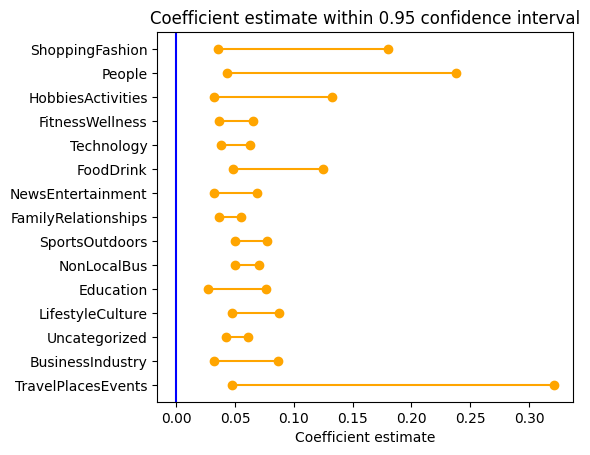

In [11]:
plot_confidence_interval(feature_dict,"Coefficient_estimate_d_tree")